# YOLO on Helmet dataset from Myanmar
### Project 09 - Deep Learning (02456)

* The first part of this notebook is data pre-processing.
* The second part is the configuration of the YOLOv5 run with custom data set.

In [ ]:
# Restore state when working larger datasets (very handy if the session died out)
#%load_ext autoreload
#%autoreload 2

In [ ]:
# Configure YOLO & OpenCV
# !pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt
# !apt install ffmpeg libsm6 libxext6 -y # Some machines require this

In [2]:
from tqdm import tqdm
import os
import shutil
import zipfile

print('Working directory:\n' + os.getcwd())

# Use this to unzip files (it seems if files already are unzipped nothing happens)
def unzip(fileName, outputDir = ''):
    with zipfile.ZipFile(os.getcwd() + '/' + fileName, 'r') as zip_ref:
        zip_ref.extractall(os.getcwd() + '/' + outputDir)

unzip_files = True
# The zip file are added in `.gitignore`. In order for this script to work these files need to be downloaded manualy.
if unzip_files:
    unzip('part_1.zip', 'data')
    unzip('part_2.zip', 'data')
    unzip('part_3.zip', 'data')
    unzip('part_4.zip', 'data')
    unzip('part_5.zip', 'data')
    unzip('part_6.zip', 'data')
    unzip('part_7.zip', 'data')
    # unzip('annotation.zip')
    

Working directory:
/home/khurram/workspace/jupyter/deep-learning-project


In [3]:
# Read classes and their respective indexes
import pandas as pd
classes = pd.read_csv('36_class.csv', sep=',', header=None, names=['class', 'index'])
print(classes)

# Helper functions
def class_name_to_id(class_name):
    return int(classes.loc[classes['class'] == class_name]['index'])

def class_id_to_name(class_id):
    return classes.loc[classes['index'] == class_id]['class'].str.cat(sep='\n')

print("\nId of class DHelmet:", class_name_to_id('DHelmet'))
print("Class of id 2:", class_id_to_name(2))

                                                class  index
0                                 DNoHelmetP1NoHelmet      0
1                                     DHelmetP1Helmet      1
2                                             DHelmet      2
3                                           DNoHelmet      3
4                                   DHelmetP1NoHelmet      4
5                         DHelmetP0NoHelmetP1NoHelmet      5
6                         DHelmetP1NoHelmetP2NoHelmet      6
7                       DNoHelmetP1NoHelmetP2NoHelmet      7
8                           DHelmetP1NoHelmetP2Helmet      8
9                                   DNoHelmetP1Helmet      9
10                DHelmetP0NoHelmetP1NoHelmetP2Helmet     10
11                      DNoHelmetP0NoHelmetP1NoHelmet     11
12                                DNoHelmetP0NoHelmet     12
13                                  DHelmetP0NoHelmet     13
14                          DNoHelmetP1HelmetP2Helmet     14
15                      

In [4]:
data_split = pd.read_csv('data_split.csv', sep=',', header=0, names=['video_id', 'Set'])
print(data_split)

# Helper functions
def get_video_set(video_id):
    return data_split.loc[data_split['video_id'] == video_id]['Set'].str.cat(sep='\n')

get_video_set('Bago_highway_9')

            video_id         Set
0     Bago_highway_1  validation
1    Bago_highway_10        test
2    Bago_highway_11    training
3    Bago_highway_12    training
4    Bago_highway_13    training
..               ...         ...
905      Yangon_II_5    training
906      Yangon_II_6        test
907      Yangon_II_7    training
908      Yangon_II_8    training
909      Yangon_II_9  validation

[910 rows x 2 columns]


'test'

In [7]:
#!/usr/bin/env python3
import shutil
import os
import sys
from pathlib import Path

directory = os.getcwd() + '/data'
destination = os.getcwd() + '/data_yolo/images'
# Create output directory if does not exists
Path(destination).mkdir(parents=True, exist_ok=True)
print(directory) 
for root, dirs, files in tqdm(os.walk(directory)):
    for f in files:
        try:
            output_by_set = destination + '/' + get_video_set(root.split("/")[-1])
            # Create output directory if does not exists
            Path(output_by_set).mkdir(parents=True, exist_ok=True)
            shutil.move(root+"/"+f, output_by_set+"/"+root.split("/")[-1]+'-'+f)
        except:
            print('')
        


3it [00:00, 23.83it/s]

/home/khurram/workspace/jupyter/deep-learning-project/data


857it [00:55, 15.39it/s]


data_yolo/images/validation/Bago_highway_1-01.jpg


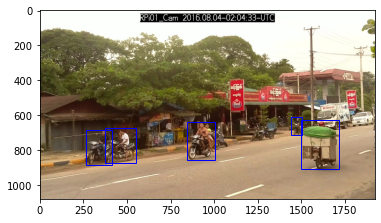

data_yolo/images/validation/Bago_highway_1-02.jpg


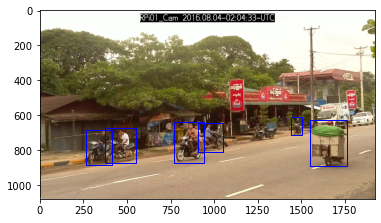

data_yolo/images/validation/Bago_highway_1-03.jpg


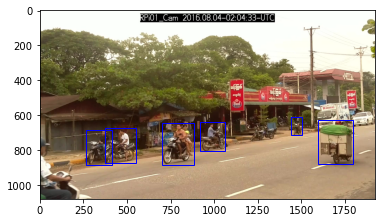

data_yolo/images/validation/Bago_highway_1-04.jpg


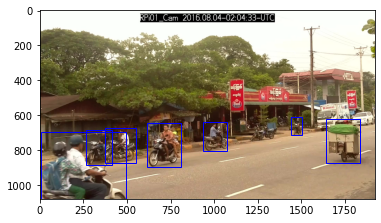

data_yolo/images/validation/Bago_highway_1-05.jpg


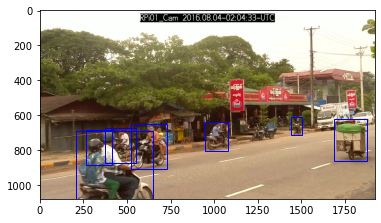

data_yolo/images/validation/Bago_highway_1-06.jpg


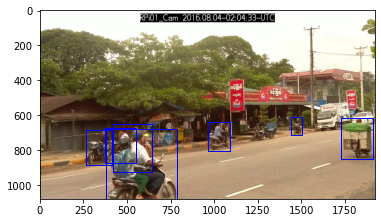

data_yolo/images/validation/Bago_highway_1-07.jpg


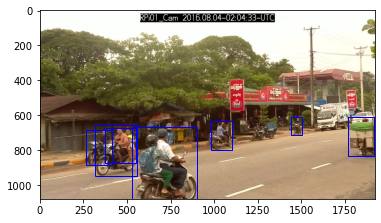

data_yolo/images/validation/Bago_highway_1-08.jpg


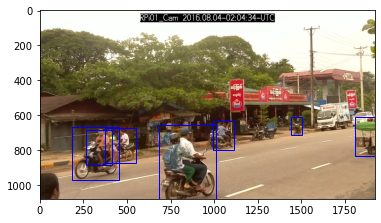

data_yolo/images/validation/Bago_highway_1-09.jpg


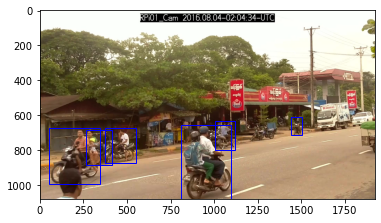

In [14]:
# Load the dataset
import csv
import matplotlib.pyplot as plt

def draw_img(file_name, frame):
    path = file_name + "-" 
    if(frame < 10):
        path += "0"
    path += str(frame) + ".jpg"
    print(path)
    img = plt.imread(path)
    plt.imshow(img)

def draw_annotation(fileName, frame):
    with open('annotation/' + fileName + '.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)

        rectangleList = []

        for row in reader:
            if (row['frame_id'] == str(frame)):
                rectangleList.append(plt.Rectangle((int(row['x']), int(row['y'])), int(row['w']), int(row['h']), fill=None, color=(0,0,1)))
        
        for rectangle in rectangleList:
            plt.gca().add_patch(rectangle)

    plt.show()

for i in range(1, 10):
    draw_img('data_yolo/images/validation/Bago_highway_1', i)
    draw_annotation('Bago_highway_1', i)

In [19]:
# Read annotation data and convert it to YOLOv5

## Read and prepare
def annotate_prepare(file_name):
    groups = pd.read_csv(file_name, sep=',', header=0).groupby('frame_id')
    # Print one group
    # print(groups.get_group(1))
    data = []
    # Create datastructure and format
    for frame, group in groups:
        annotation = {}
        annotation['filename'] = str(frame)
        annotation['image_size'] = tuple(['1920', '1080'])
        annotation['bboxes'] = []
        #print(formatted)
        #print(frame, group)
        for _, row in group.iterrows():
            bbox = {}
            bbox['id'] = row['track_id']
            bbox['class'] = row['label']
            bbox['x'] = row['x']
            bbox['y'] = row['y']
            bbox['w'] = row['w']
            bbox['h'] = row['h']
            annotation['bboxes'].append(bbox)
        # print(annotation)
        data.append(annotation)
    return data

# TEST CODE
bago_highway_1 = annotate_prepare('annotation/Bago_highway_1.csv')
print(bago_highway_1[2])

{'filename': '3', 'image_size': ('1920', '1080'), 'bboxes': [{'id': '_x4f29hsem', 'class': 'DNoHelmetP1NoHelmetP2NoHelmet', 'x': 698, 'y': 646, 'w': 185, 'h': 240}, {'id': '_uy9yux9zv', 'class': 'DNoHelmet', 'x': 920, 'y': 641, 'w': 141, 'h': 166}, {'id': '_q4b18swgd', 'class': 'DHelmet', 'x': 1598, 'y': 625, 'w': 200, 'h': 257}, {'id': '_q6v32gn0z', 'class': 'DNoHelmet', 'x': 267, 'y': 684, 'w': 147, 'h': 201}, {'id': '_ov2h9m3ux', 'class': 'DNoHelmet', 'x': 373, 'y': 676, 'w': 180, 'h': 199}, {'id': '_ol6avrrr2', 'class': 'DHelmet', 'x': 1441, 'y': 613, 'w': 62, 'h': 103}]}


In [24]:
## Convert to YOLO5
def annotate_yolo5(frame_annotation, output_path, directory_prefix):
    print_buffer = []
    
    for box in frame_annotation['bboxes']:
        try:
            class_id = class_name_to_id(box['class'])
        except KeyError:
            print("Invalid class")
        
        # Transform the bounding box as per the format required by YOLO5
        box_center_x = box['x'] + (box['w'] / 2)
        box_center_y = box['y'] + (box['h'] / 2)
        box_width    = box['w']
        box_height   = box['h']
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h = frame_annotation["image_size"]
        box_center_x /= float(image_w) 
        box_center_y /= float(image_h) 
        box_width    /= float(image_w) 
        box_height   /= float(image_h)
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, box_center_x, box_center_y, box_width, box_height))

    # Name of the file which we have to save
    #output_path.split('/')[1]
    annotation_name = '0' + frame_annotation['filename'] if int(frame_annotation['filename']) < 10 else frame_annotation['filename']
    save_file_name = os.path.join(output_path, directory_prefix +'-' + annotation_name + '.txt')
    save_file_data = "\n".join(print_buffer)

    # Save the annotation to disk
    print(save_file_data, file = open(save_file_name, "w"))

# TEST CODE
#annotate_yolo5(bago_highway_1[2], 'part_1/Bago_highway_1', 'test-dir-prefix')

In [25]:
# Convert all annotations and save them as .txt files
from pathlib import Path

# Flag to convert annotations to YOLOv5 format default `False`
run_yolo5_annotation_conversion = False

output_path = os.getcwd() + '/data_yolo/labels/'

if run_yolo5_annotation_conversion:
    # Get the annotations
    annotations = [os.path.join('annotation', x) for x in os.listdir('annotation') if x[-3:] == "csv"]
    annotations.sort()
    print("Annotation count:", len(annotations))

    # Create output directory if does not exists
    Path(output_path).mkdir(parents=True, exist_ok=True)
    
    for annotation in tqdm(annotations):
        prepared_output = annotate_prepare(annotation)
        directory_prefix = annotation.split('/')[1].split('.')[0]
        
        # Get the video set id
        output_by_set = output_path + '/' + get_video_set(directory_prefix)
        # Create output directory if does not exists
        Path(output_by_set).mkdir(parents=True, exist_ok=True)
    
        for prepared_frame in prepared_output:
            annotate_yolo5(prepared_frame, output_by_set, directory_prefix)

  0%|          | 0/910 [00:00<?, ?it/s]

Annotation count: 910


100%|██████████| 910/910 [03:05<00:00,  4.92it/s]


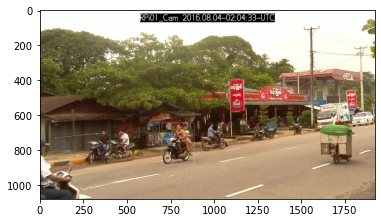

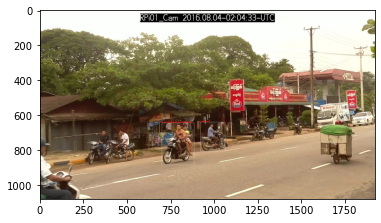

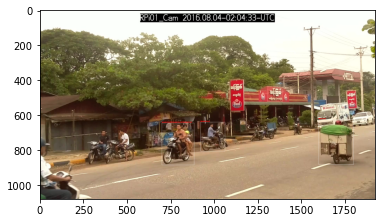

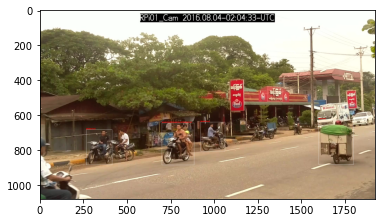

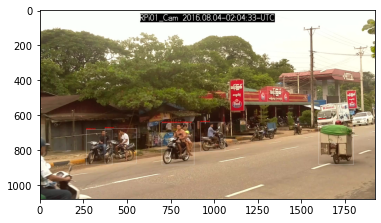

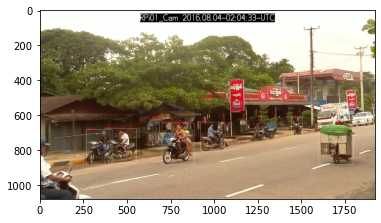

In [27]:
# Test the annotations to be correctly calculated

from PIL import Image, ImageDraw
import numpy as np

def plot_bounding_box(frame, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(frame)
    
    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
 
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name(int(obj_cls)), fill=(255,0,0,255))
    
        plt.imshow(np.array(image))
        plt.show()

# Get any random annotation file 
annotation_file = 'data_yolo/labels/validation/Bago_highway_1-03.txt'
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = 'data_yolo/images/validation/Bago_highway_1-03.jpg'
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
#import torch
# !pip install opencv-python
#import cv2
# Model
#model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3432fd26-5b91-468a-a89c-15a295636b95' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>